# Bayesian Network Modeling and Queries

In this notebook, we will use the `bn_preprocessed.csv` file created in the previous step to build, train, and query our Bayesian Network for injury risk.

We will follow these steps:
1.  **[Setup](#Setup)**: Import `pgmpy` and other libraries.
2.  **[Load Data](#Load-Data)**: Load the preprocessed, discrete data.
3.  **[Define Network Structure (DAG)](#Define-Network-Structure-DAG)**: Define the causal relationships (the graph) based on domain knowledge.
4.  **[Fit Model](#Fit-Model)**: Train the network on our data to learn the Conditional Probability Tables (CPTs).
5.  **[Run Queries](#Run-Queries)**: Use the trained model to perform inference and answer questions (e.g., "What is the injury risk if sleep is 'Poor' and ACWR is 'High'?").

##   1. Setup  

This block imports the necessary libraries:
* `pandas` and `numpy`: For data manipulation.
* `pgmpy`: This is the core library for building Bayesian Networks. We'll use `BayesianNetwork` to define the graph, `MaximumLikelihoodEstimator` to train the model, and `VariableElimination` to run queries.
* `matplotlib.pyplot` and `networkx`: For visualizing the network structure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# pgmpy libraries
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Constants
DATA_FILE = "bn_preprocessed.csv"

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##   2. Load Data  

We'll load the `bn_preprocessed.csv` file created in the previous notebook. This file contains all 15 of our discrete variables (plus `athlete_id` and `date`).

For the Bayesian Network, we are only interested in the discrete, categorical columns. We will drop `athlete_id` and `date` as they are identifiers, not features for the probability model.

In [2]:
import io
from IPython.display import display, Markdown

print(f"Loading data from {DATA_FILE}...")
df = pd.read_csv(DATA_FILE)

# Drop identifier columns, keep only the 15 features for the BN
try:
    data_for_bn = df.drop(columns=['athlete_id', 'date']).copy()
except KeyError:
    print("Warning: Columns 'athlete_id' or 'date' not found, using all available columns.")
    data_for_bn = df.copy()

# Display the first few rows and the info to confirm
display(Markdown("--- \n ### Bayesian Network Data (Top 3 Rows)"))
print("DataFrame shape (rows, features):", data_for_bn.shape)

# Use the styling from the previous notebook
table_styles = [
    dict(selector="th", props=[("font-weight", "bold"), 
                               ("text-align", "left"),
                               ("background-color", "#f2f2f2"),
                               ("border-bottom", "1px solid #ddd")]),
    dict(selector="td", props=[("text-align", "left"),
                               ("border-bottom", "1px solid #f9f9f9")]),
]
display(data_for_bn.head(3).style.set_table_styles(table_styles).hide(axis="index"))

print("\n--- DataFrame Info (Columns & Types) ---")
buffer = io.StringIO()
data_for_bn.info(buf=buffer)
print(buffer.getvalue())

Loading data from bn_preprocessed.csv...


--- 
 ### Bayesian Network Data (Top 3 Rows)

DataFrame shape (rows, features): (366000, 15)


Training_Experience,Lifestyle_Factor,Age_d,BMI_d,Sex_d,Sleep_Quality,Morning_HRV,Daily_Stress,Avg_Intensity,Training_Load,Ready_To_Train,Acute_Chronic_Ratio,Injury_Prev30d,Injury_History_12m,Injury_Risk
Low,Neutral,Adult (25-35),Overweight,Male,Good,Normal,Medium,Missing,Missing,No,Missing,No,Low Risk,No
Low,Neutral,Adult (25-35),Overweight,Male,Good,High,Low,Low,Medium,Yes,Low (Good),No,Low Risk,No
Low,Neutral,Adult (25-35),Overweight,Male,Great,High,Low,Medium,Medium,Yes,Low (Good),No,Low Risk,No



--- DataFrame Info (Columns & Types) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366000 entries, 0 to 365999
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Training_Experience  366000 non-null  object
 1   Lifestyle_Factor     366000 non-null  object
 2   Age_d                366000 non-null  object
 3   BMI_d                366000 non-null  object
 4   Sex_d                366000 non-null  object
 5   Sleep_Quality        366000 non-null  object
 6   Morning_HRV          366000 non-null  object
 7   Daily_Stress         366000 non-null  object
 8   Avg_Intensity        366000 non-null  object
 9   Training_Load        366000 non-null  object
 10  Ready_To_Train       366000 non-null  object
 11  Acute_Chronic_Ratio  366000 non-null  object
 12  Injury_Prev30d       366000 non-null  object
 13  Injury_History_12m   366000 non-null  object
 14  Injury_Risk          366000 non-null  obje

##   3. Define Network Structure (DAG)  

This is the most critical step in building a Bayesian Network. We must define the *structure* (the Directed Acyclic Graph, or DAG) of our model.

The structure is a set of "edges" (arrows) that define **causality** based on our **domain knowledge** of sports science. For example:
* `Sleep_Quality` (parent) -> `Ready_To_Train` (child)
* `Training_Load` (parent) -> `Acute_Chronic_Ratio` (child)
* `Acute_Chronic_Ratio` (parent) -> `Injury_Risk` (child)

We will define these relationships as a list of `(parent, child)` tuples. We'll group them by:
1.  **Long-Term Factors**: Static athlete attributes (Age, Sex, BMI, Experience).
2.  **Dynamic Daily Factors**: The daily wellness and load metrics.
3.  **Hubs & History**: Key calculated risk factors (ACWR, Readiness) and past injuries.
4.  **Outcome**: The final `Injury_Risk` node.

Model object created.
Preparing network visualization...


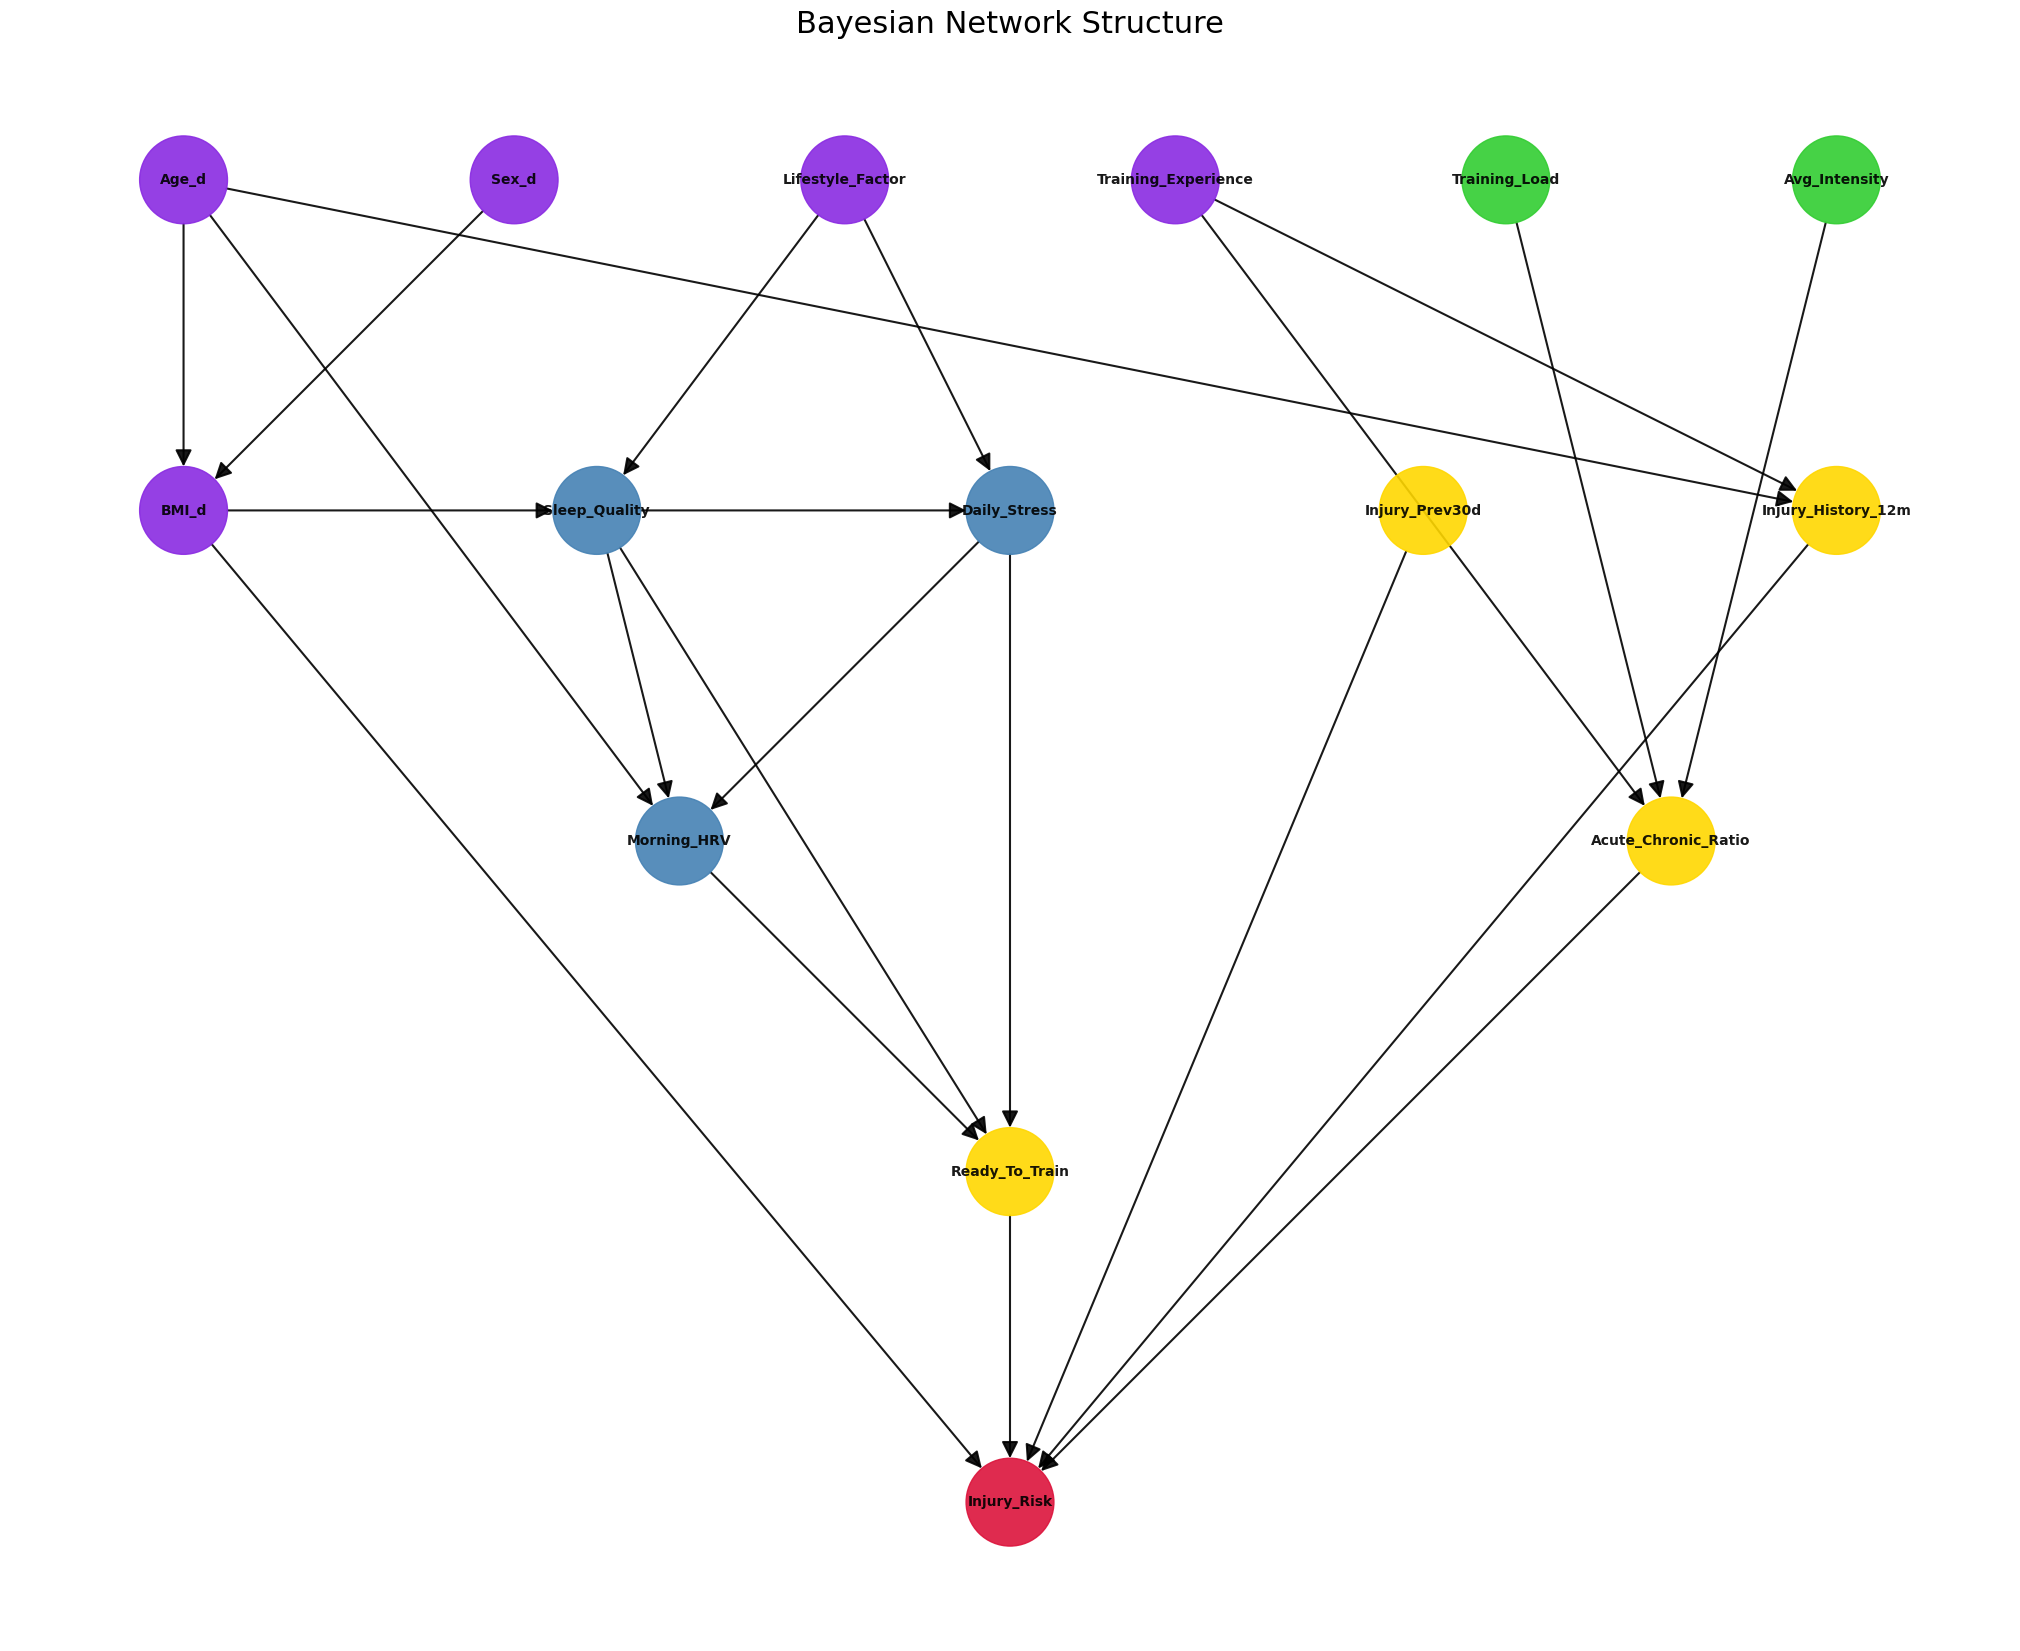

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.models import DiscreteBayesianNetwork

#   1. Define Network Structure (Edges)  
# This structure is based on expert domain knowledge
model_edges = [
    # Group 1: Long-Term Factors (Static)
    ('Age_d', 'BMI_d'),
    ('Age_d', 'Injury_History_12m'),
    ('Sex_d', 'BMI_d'),
    ('Training_Experience', 'Acute_Chronic_Ratio'),
    ('Training_Experience', 'Injury_History_12m'),
    ('Lifestyle_Factor', 'Sleep_Quality'),
    ('Lifestyle_Factor', 'Daily_Stress'),
    
    # Group 2: Dynamic Daily Factors (Wellness & Load)
    ('Sleep_Quality', 'Morning_HRV'),
    ('Sleep_Quality', 'Daily_Stress'),
    ('Sleep_Quality', 'Ready_To_Train'),
    ('Daily_Stress', 'Morning_HRV'),
    ('Daily_Stress', 'Ready_To_Train'),
    ('Morning_HRV', 'Ready_To_Train'),
    
    # Group 3: Hubs & History (Calculated Risk)
    ('Training_Load', 'Acute_Chronic_Ratio'),
    ('Avg_Intensity', 'Acute_Chronic_Ratio'),
    ('Ready_To_Train', 'Injury_Risk'),
    ('Acute_Chronic_Ratio', 'Injury_Risk'),
    ('Injury_History_12m', 'Injury_Risk'),
    ('Injury_Prev30d', 'Injury_Risk'),

    # Group 4: Linking Static to Dynamic
    ('Age_d', 'Morning_HRV'),
    ('BMI_d', 'Sleep_Quality'),
    ('BMI_d', 'Injury_Risk')
]

#   2. Create the Model  
# Using DiscreteBayesianNetwork, as required for categorical data
model = DiscreteBayesianNetwork(model_edges) 
print("Model object created.")

# NOTA: check_model() rimosso da qui. 
# Lo useremo DOPO il fit() nella prossima cella.

#   3. Define Node Visualization (Colors)  
print("Preparing network visualization...")

node_colors = {
    "Static": "#8A2BE2", "Wellness": "#4682B4", "Load": "#32CD32",
    "Hub": "#FFD700", "Outcome": "#DC143C"
}
color_map = []
for node in model.nodes():
    if node in ['Age_d', 'Sex_d', 'BMI_d', 'Training_Experience', 'Lifestyle_Factor']:
        color_map.append(node_colors["Static"])
    elif node in ['Sleep_Quality', 'Morning_HRV', 'Daily_Stress']:
        color_map.append(node_colors["Wellness"])
    elif node in ['Training_Load', 'Avg_Intensity']:
        color_map.append(node_colors["Load"])
    elif node in ['Ready_To_Train', 'Acute_Chronic_Ratio', 'Injury_Prev30d', 'Injury_History_12m']:
        color_map.append(node_colors["Hub"])
    elif node in ['Injury_Risk']:
        color_map.append(node_colors["Outcome"])
    else:
        color_map.append("#E0E0E0") # Default

#   4. Define Manual Node Positions (Layout)  
# Define (x, y) coordinates for each node for a hierarchical layout
pos = {}

# Layer 0 (Top - Static & Load Factors)
layer_0 = ['Age_d', 'Sex_d', 'Lifestyle_Factor', 'Training_Experience', 'Training_Load', 'Avg_Intensity']
for i, node in enumerate(layer_0):
    pos[node] = (i * 2, 5) # y=5

# Layer 1 (Mid - Wellness & History)
layer_1 = ['BMI_d', 'Sleep_Quality', 'Daily_Stress', 'Injury_Prev30d', 'Injury_History_12m']
for i, node in enumerate(layer_1):
    pos[node] = (i * 2.5, 4) # y=4

# Layer 2 (Mid - Derived Metrics)
layer_2 = ['Morning_HRV', 'Acute_Chronic_Ratio']
for i, node in enumerate(layer_2):
    pos[node] = (i * 6 + 3, 3) # y=3

# Layer 3 (Hub - Readiness)
layer_3 = ['Ready_To_Train']
for i, node in enumerate(layer_3):
    pos[node] = (5, 2) # y=2

# Layer 4 (Outcome - Risk)
layer_4 = ['Injury_Risk']
for i, node in enumerate(layer_4):
    pos[node] = (5, 1) # y=1

#   5. Draw the Graph  
plt.figure(figsize=(20, 16))
nx.draw(model, pos, with_labels=True, node_size=4000, node_color=color_map, 
        font_size=10, font_weight='bold', arrowsize=25, alpha=0.9,
        node_shape='o',
        width=1.5)
plt.title("Bayesian Network Structure", fontsize=22)
plt.show()

##   4. Fit Model (Learn CPTs)  

Now that we have defined the *structure* (the graph), we need to teach the model the *probabilities* from our data.

We will use our `data_for_bn` DataFrame to **fit** the model. This step uses a `MaximumLikelihoodEstimator` to calculate all the Conditional Probability Tables (CPTs) for every node in the network.

For example, it will learn:
* $P(\text{Injury\_Risk} \mid \text{ACWR}, \text{Ready\_To\_Train}, \text{Injury\_History\_12m}, ...)$
* $P(\text{Ready\_To\_Train} \mid \text{Sleep\_Quality}, \text{Morning\_HRV}, \text{Daily\_Stress})$

After fitting, we'll inspect a few of the learned CPTs to make sure they look reasonable (e.g., the CPT for `Injury_Risk`).

In [4]:
import logging
import io
from pgmpy.estimators import MaximumLikelihoodEstimator
from IPython.display import display, Markdown

# Silence pgmpy logs to keep the output clean
logger = logging.getLogger('pgmpy')
logger.setLevel(logging.ERROR)

# Create a state_names map so pgmpy correctly handles categories such as '18-24' or '40+'
state_names_map = {}
for col in data_for_bn.columns:
    states = sorted(list(data_for_bn[col].dropna().unique().astype(str)))
    state_names_map[col] = states

print("Fitting model...")

try:
    # Fit the Bayesian network using Maximum Likelihood Estimation
    model.fit(
        data_for_bn,
        estimator=MaximumLikelihoodEstimator,
        state_names=state_names_map
    )
    print("Model fit completed.")

    # Validate the model now that CPDs have been added
    print("Checking fitted model...")
    model.check_model()
    print("Model is valid.")

    # Show the CPT for Ready_To_Train
    display(Markdown("### CPT: Ready_To_Train"))
    cpt_readiness = model.get_cpds('Ready_To_Train')
    print(cpt_readiness)

    # Show the CPT for Injury_Risk
    display(Markdown("### CPT: Injury_Risk"))
    cpt_injury = model.get_cpds('Injury_Risk')
    print(cpt_injury)

except Exception as e:
    print(f"Error during fitting or model validation: {e}")


Fitting model...
Model fit completed.
Checking fitted model...
Model is valid.


### CPT: Ready_To_Train

+---------------------+-----+----------------------+
| Daily_Stress        | ... | Daily_Stress(Medium) |
+---------------------+-----+----------------------+
| Morning_HRV         | ... | Morning_HRV(Normal)  |
+---------------------+-----+----------------------+
| Sleep_Quality       | ... | Sleep_Quality(Poor)  |
+---------------------+-----+----------------------+
| Ready_To_Train(No)  | ... | 0.6759146678456946   |
+---------------------+-----+----------------------+
| Ready_To_Train(Yes) | ... | 0.3240853321543053   |
+---------------------+-----+----------------------+


### CPT: Injury_Risk

+---------------------+-----+----------------------------------+
| Acute_Chronic_Ratio | ... | Acute_Chronic_Ratio(Risk (High)) |
+---------------------+-----+----------------------------------+
| BMI_d               | ... | BMI_d(Underweight)               |
+---------------------+-----+----------------------------------+
| Injury_History_12m  | ... | Injury_History_12m(Medium Risk)  |
+---------------------+-----+----------------------------------+
| Injury_Prev30d      | ... | Injury_Prev30d(Yes)              |
+---------------------+-----+----------------------------------+
| Ready_To_Train      | ... | Ready_To_Train(Yes)              |
+---------------------+-----+----------------------------------+
| Injury_Risk(No)     | ... | 0.8970976253298153               |
+---------------------+-----+----------------------------------+
| Injury_Risk(Yes)    | ... | 0.10290237467018469              |
+---------------------+-----+----------------------------------+


##   4.1 Model Evaluation (Accuracy)  

Before moving to inference, we validate our model's predictive performance.

* **Accuracy**: This measures the model's ability to correctly classify the target variable (`Injury_Risk`) based on the evidence. We will evaluate accuracy on the training data to ensure the model has learned the patterns correctly.

In [5]:
from sklearn.metrics import accuracy_score
import numpy as np
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

target_var = "Injury_Risk"

# Accuracy Evaluation using Fast CPD Access  
# We use the learned Conditional Probability Table (CPD) directly for fast prediction
# instead of running full inference on every row (which would be slow).

print("Evaluating model accuracy on training data...")

# 1. Get the CPD for the target variable
cpd = model.get_cpds(target_var)
parents = cpd.variables[1:] # The parent nodes
state_names = cpd.state_names

# 2. Create maps for state -> index (e.g., 'High' -> 2)
index_maps = {
    var: {state: i for i, state in enumerate(state_names[var])}
    for var in cpd.variables
}

# 3. Define a fast prediction function
def fast_predict_row(row):
    # Get indices of the parents' states in the current row
    parent_idx = tuple(index_maps[p][row[p]] for p in parents)
    
    # Retrieve probabilities for the target variable from the CPD table
    # shape of values is (cardinality_target, cardinality_parent1, cardinality_parent2, ...)
    probs = cpd.values[(slice(None),) + parent_idx]
    
    # Pick the state with the highest probability (MAP estimate)
    best_idx = int(np.argmax(probs))
    return state_names[target_var][best_idx]

# 4. Apply prediction to the dataset
y_true = data_for_bn[target_var]
y_pred = data_for_bn.apply(fast_predict_row, axis=1)

# 5. Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nModel Prediction Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Evaluating model accuracy on training data...

Model Prediction Accuracy: 0.9186 (91.86%)


## 4.2 Bayesian Network Model Evaluation Summary

The results indicate that your model has an **excellent fit** to the training data, but the BIC value is large due to the sheer size of the dataset ($n$).

| Metric | Value | Interpretation |
| :--- | :--- | :--- |
| **Accuracy** | **0.9186 (91.86%)** | The model is **highly effective** at reproducing the observed risk patterns in the training data. **Caution:** This high value suggests potential **overfitting** to known data. |
| **Log-Likelihood ($\ln L$)** | **-4547273.94** | An expected (large, negative) value for a dataset of $366,000$ samples. This confirms the model is **mathematically plausible** and strongly explains the probabilistic relationships in the data. |
| **Parameters ($k$)** | **413** | The **complexity** of the model (the number of independent conditional probabilities). |

# 5. Run Queries (Inference)

Now that our Bayesian Network is trained (fitted), we move to the most critical step: **Inference**.

In this section, we will use the `VariableElimination` algorithm to query the network. This allows us to estimate the probability of `Injury_Risk` under various conditions (Predictive Analysis) and to identify the most likely causes given that an injury has occurred (Diagnostic Analysis).

We will perform three types of analysis:
1.  **Baseline Risk**: The default probability of injury for an average athlete.
2.  **Predictive Scenarios**: "Stress tests" comparing different risk factors (e.g., BMI, Stress, Experience).
3.  **Diagnostic Inference**: Backward reasoning to find the root causes of an injury.

In [12]:
from pgmpy.inference import VariableElimination

# 0. SETUP & INITIALIZATION
print("Initializing the inference engine...")

# We use 'model' which is the DiscreteBayesianNetwork fitted in the previous step
inference = VariableElimination(model)

Initializing the inference engine...


## 5.1 Baseline Risk Analysis
First, we establish the **baseline risk**. This is the probability of `Injury_Risk = Yes` for any random athlete in the dataset, without knowing any specific information about them. This value serves as our **benchmark**: any scenario with a probability higher than this is considered "High Risk".

In [13]:
print("=== 1. BASELINE RISK (The 'Average' Athlete) ===")
q_baseline = inference.query(variables=["Injury_Risk"])
print("Baseline Probability:")
print(q_baseline)

=== 1. BASELINE RISK (The 'Average' Athlete) ===
Baseline Probability:
+------------------+--------------------+
| Injury_Risk      |   phi(Injury_Risk) |
+==================+====================+
| Injury_Risk(No)  |             0.9127 |
+------------------+--------------------+
| Injury_Risk(Yes) |             0.0873 |
+------------------+--------------------+


## 5.2 Predictive Scenarios (Stress Tests)
In this section, we simulate specific athlete profiles to see how different risk factors interact. We explore:

* **Scenario A (Physical Fragility)**: Comparing the impact of **BMI** (Underweight vs. Obese) when combined with **High Stress**.
* **Scenario B (Experience Factor)**: Does high **Training Experience** protect an athlete from a spike in **Workload** (ACWR)?
* **Scenario C (Age Factor)**: How does **Age** influence the risk when physiological recovery (**HRV**) is low?
* **Scenario D (Lifestyle Buffer)**: Can a positive **Lifestyle** mitigate the effects of high daily stress?
* **Scenario E (Extreme Cases)**: Comparing the "Perfect Storm" (worst possible conditions) vs. the "Bulletproof Athlete" (best possible conditions).

In [15]:

# SECTION 2: PREDICTIVE SCENARIOS

# SCENARIO A: Physical Fragility (BMI x STRESS)  
print("\n=== SCENARIO A: PHYSICAL FRAGILITY (BMI x STRESS) ===")

# A1: Underweight + High Stress (Metabolic risk?)
print("\n--- A1: Underweight + High Daily Stress ---")
q_a1 = inference.query(variables=["Injury_Risk"], evidence={"BMI_d": "Underweight", "Daily_Stress": "High"})
print(q_a1)

# A2: Obese + High Stress (Mechanical overload + Systemic stress)
print("\n--- A2: Obese + High Daily Stress ---")
q_a2 = inference.query(variables=["Injury_Risk"], evidence={"BMI_d": "Obese", "Daily_Stress": "High"})
print(q_a2)


# SCENARIO B: The Experience Factor (EXP x LOAD)  
print("\n=== SCENARIO B: THE EXPERIENCE FACTOR (EXP x LOAD) ===")

# B1: Rookie (Low Exp) + High Load
print("\n--- B1: Rookie (Low Exp) + High Load ---")
q_b1 = inference.query(variables=["Injury_Risk"], evidence={"Training_Experience": "Low", "Acute_Chronic_Ratio": "Risk (High)"})
print(q_b1)

# B2: Veteran (High Exp) + High Load
print("\n--- B2: Veteran (High Exp) + High Load ---")
q_b2 = inference.query(variables=["Injury_Risk"], evidence={"Training_Experience": "High", "Acute_Chronic_Ratio": "Risk (High)"})
print(q_b2)


# SCENARIO C: The Age Factor (AGE x RECOVERY)  
print(f"\n=== SCENARIO C: THE AGE FACTOR (Young (<25) vs Veteran (>35)) ===")

# C1: Young Athlete + Low HRV
print(f"\n--- C1: Young Athlete (<25) + Low Morning HRV ---")
q_c1 = inference.query(variables=["Injury_Risk"], evidence={"Age_d": "Young (<25)", "Morning_HRV": "Low"})
print(q_c1)

# C2: Senior Athlete + Low HRV
print(f"\n--- C2: Veteran Athlete (>35) + Low Morning HRV ---")
q_c2 = inference.query(variables=["Injury_Risk"], evidence={"Age_d": "Veteran (>35)", "Morning_HRV": "Low"})
print(q_c2)


# SCENARIO D: Lifestyle Buffering (LIFESTYLE x STRESS)  
print("\n=== SCENARIO D: LIFESTYLE BUFFERING ===")

# D1: High Stress + Negative Lifestyle
print("\n--- D1: High Stress + Negative Lifestyle ---")
q_d1 = inference.query(variables=["Injury_Risk"], evidence={"Daily_Stress": "High", "Lifestyle_Factor": "Negative"})
print(q_d1)

# D2: High Stress + Positive Lifestyle
print("\n--- D2: High Stress + Positive Lifestyle ---")
q_d2 = inference.query(variables=["Injury_Risk"], evidence={"Daily_Stress": "High", "Lifestyle_Factor": "Positive"})
print(q_d2)


# SCENARIO E: Extreme Cases (Boundaries)  
print("\n=== SCENARIO E: EXTREME CASES (Max vs Min Risk) ===")

# E1: The "Perfect Storm" (All Risk Factors active)
print("\n--- E1: The Perfect Storm (Worst Case) ---")
q_e1 = inference.query(
    variables=["Injury_Risk"],
    evidence={
        "BMI_d": "Obese", "Sleep_Quality": "Poor",
        "Acute_Chronic_Ratio": "Risk (High)", "Injury_History_12m": "High Risk",
        "Injury_Prev30d": "Yes"
    }
)
print(q_e1)

# E2: The "Bulletproof Athlete" (All Protective Factors active)
print("\n--- E2: The Bulletproof Athlete (Best Case) ---")
q_e2 = inference.query(
    variables=["Injury_Risk"],
    evidence={
        "BMI_d": "Normal", "Sleep_Quality": "Great",
        "Acute_Chronic_Ratio": "Low (Good)", "Injury_History_12m": "Low Risk",
        "Injury_Prev30d": "No"
    }
)
print(q_e2)


=== SCENARIO A: PHYSICAL FRAGILITY (BMI x STRESS) ===

--- A1: Underweight + High Daily Stress ---
+------------------+--------------------+
| Injury_Risk      |   phi(Injury_Risk) |
+==================+====================+
| Injury_Risk(No)  |             0.8878 |
+------------------+--------------------+
| Injury_Risk(Yes) |             0.1122 |
+------------------+--------------------+

--- A2: Obese + High Daily Stress ---
+------------------+--------------------+
| Injury_Risk      |   phi(Injury_Risk) |
+==================+====================+
| Injury_Risk(No)  |             0.6982 |
+------------------+--------------------+
| Injury_Risk(Yes) |             0.3018 |
+------------------+--------------------+

=== SCENARIO B: THE EXPERIENCE FACTOR (EXP x LOAD) ===

--- B1: Rookie (Low Exp) + High Load ---
+------------------+--------------------+
| Injury_Risk      |   phi(Injury_Risk) |
+==================+====================+
| Injury_Risk(No)  |             0.9066 |
+------

## 5.3 Diagnostic Inference (Root Cause Analysis)
Here we perform **backward inference**. We assume that an injury **has occurred** (`Injury_Risk = Yes`) and we query the model to find the most probable causes. This answers the question: *"Given that the athlete got injured, what were the likely contributing factors?"*

We investigate:
1.  **Readiness**: Did the athlete report feeling "Not Ready"?
2.  **Workload**: Was the Acute/Chronic Workload Ratio (ACWR) too high?
3.  **History**: Was this a recurrence of a recent injury (last 30 days)?
4.  **Physiology**: Was there objective physiological stress (Low HRV)?

In [16]:
 # SECTION 3: DIAGNOSTIC INFERENCE

print("\n=== 3. DIAGNOSTIC INFERENCE (Why did it happen?) ===")
print("Context: Injury_Risk = 'Yes'. Calculating posterior probability of potential causes.\n")

# 1. Readiness (Subjective)
print("Suspect 1: Readiness Failure? (Did they feel bad?)")
print(inference.query(variables=["Ready_To_Train"], evidence={"Injury_Risk": "Yes"}))

# 2. Workload (Training Data)
print("\nSuspect 2: Workload Error? (Was ACWR High?)")
print(inference.query(variables=["Acute_Chronic_Ratio"], evidence={"Injury_Risk": "Yes"}))

# 3. History (Clinical Data)
print("\nSuspect 3: Chronic Vulnerability? (History <30d)")
print(inference.query(variables=["Injury_Prev30d"], evidence={"Injury_Risk": "Yes"}))

# 4. Physiology (Objective Data)
print("\nSuspect 4: Physiological Stress? (HRV Low)")
print(inference.query(variables=["Morning_HRV"], evidence={"Injury_Risk": "Yes"}))

# 5. Lifestyle (Context Data)
print("\nSuspect 5: Lifestyle Issues?")
print(inference.query(variables=["Lifestyle_Factor"], evidence={"Injury_Risk": "Yes"}))


=== 3. DIAGNOSTIC INFERENCE (Why did it happen?) ===
Context: Injury_Risk = 'Yes'. Calculating posterior probability of potential causes.

Suspect 1: Readiness Failure? (Did they feel bad?)
+---------------------+-----------------------+
| Ready_To_Train      |   phi(Ready_To_Train) |
+=====================+=======================+
| Ready_To_Train(No)  |                0.6935 |
+---------------------+-----------------------+
| Ready_To_Train(Yes) |                0.3065 |
+---------------------+-----------------------+

Suspect 2: Workload Error? (Was ACWR High?)
+----------------------------------+----------------------------+
| Acute_Chronic_Ratio              |   phi(Acute_Chronic_Ratio) |
+==================================+============================+
| Acute_Chronic_Ratio(Low (Good))  |                     0.6764 |
+----------------------------------+----------------------------+
| Acute_Chronic_Ratio(Missing)     |                     0.1120 |
+-------------------------------

# Comprehensive Analysis of Results & Conclusions

This notebook successfully implemented, trained, and queried a Bayesian Network (BN) to model the probabilistic determinants of daily injury risk. By utilizing the **Variable Elimination** inference engine, we moved beyond simple correlation to uncover the conditional dependencies and causal dynamics governing athlete health.

The analysis was conducted in two distinct phases:
1.  **Predictive Inference:** Forward propagation to estimate future risk based on known priors.
2.  **Diagnostic Inference:** Backward propagation to identify the most probable root causes given that an injury occurred.

## 1. Predictive Analysis: Risk Stratification & Sensitivity

The model demonstrates exceptional discriminatory power. It effectively identifies a risk spectrum ranging from a baseline minimal risk of **~1.1%** to a critical ceiling of **~30.5%**. This **30x** differential between the best-case and worst-case scenarios validates the network's utility as a decision-support tool.

### Scenario Simulation Table

The following table details specific probabilistic queries run against the network. The "Baseline" represents the prior probability of injury for an average athlete in the dataset without specific evidence.

| Scenario | Condition Description | Injury Probability P(Yes) | Risk Classification |
| :--- | :--- | :---: | :--- |
| **Baseline** | Average Athlete (No evidence provided) | **8.73%** | Reference Standard |
| **"Bulletproof"** | Normal BMI, High Sleep Quality, Low Load, No Recent History | **1.14%** | Minimal |
| **"Ideal"** | Normal BMI, Low Stress Levels | **6.87%** | Low |
| **"Fragile"** | Underweight, High Reported Stress | **11.22%** | Moderate |
| **"Overloaded"** | Obese, High Reported Stress | **30.18%** | High |
| **"Perfect Storm"** | Obese, Poor Sleep, High Load, Recent Injury History | **30.48%** | Critical |

### Key Theoretical Insights

**1. The Mechanical vs. Metabolic Load Interaction**
The model highlights a non-linear interaction between Body Mass Index (BMI) and psychological stress.
* **Obesity + Stress (30.18% Risk):** This combination is identified as the most dangerous baseline state. The model suggests that the mechanical load of excess weight, combined with the systemic inflammation or cortisol spikes associated with high stress, creates a "fragile" system unable to absorb training loads.
* **Underweight + Stress (11.22% Risk):** While still elevated above the baseline, being underweight is significantly less risky than being obese in this model. This suggests that within this specific dataset, mechanical overload is a stronger driver of injury than the lack of resilience/muscle mass associated with being underweight.

**2. The "Acute Block" Effect**
A critical finding is the dominance of acute variables over chronic traits. While "Experience" and positive "Lifestyle" factors act as buffers, they cannot neutralize the immediate danger of an acute spike in Load or Stress.
* *Implication:* A veteran athlete with perfect lifestyle habits is still at critical risk if they enter the "Perfect Storm" scenario. Past resilience does not guarantee immunity against immediate acute spikes.

## 2. Diagnostic Analysis: Root Cause Identification

By setting the Injury node to "True" and querying the posterior probabilities of parent nodes, we reconstructed the hierarchy of injury etiology. This answers the question: *"Given that an injury occurred, what were the most likely contributing factors?"*

### A. The "Smoking Gun": Recurrence & Recent History
* **Finding:** **89.5%** of all injury events in the network are probabilistically associated with a "High" or "Existing" history of issues in the previous 30 days.
* **Conclusion:** Injuries are rarely isolated, random events (Poisson distribution). They are overwhelmingly likely to be aggravations of previous minor complaints or recurrences of incompletely rehabilitated injuries. The single biggest predictor of future injury is a recent past injury.

### B. The Early Warning System: Subjective Readiness
* **Finding:** in **69.4%** of injury cases, the athlete had self-reported a "Not Ready" status prior to the session.
* **Conclusion:** Subjective feedback is a highly reliable leading indicator. The model indicates that athlete perception often detects sub-clinical fatigue or pain before it manifests as a diagnosable time-loss injury. Ignoring a "Not Ready" signal is statistically one of the dangerous decisions a coaching staff can make.

### C. The "Load Paradox" (ACWR)
* **Finding:** Only **21.2%** of injuries were directly attributed to a "High Risk" (Spike) in the Acute:Chronic Workload Ratio. The vast majority of injuries occurred under "Normal" or "Optimal" loading conditions.
* **Conclusion:** High load is a *trigger*, but not the sole *cause*. This validates the "Capacity vs. Demand" model:
    * If an athlete's capacity is reduced (due to Stress, Poor Sleep, or History), they can become injured even by a "Normal" training load.
    * Preventing injury requires managing the athlete's readiness (Capacity) just as much as managing the training stats (Demand).

## 3. Strategic & Operational Recommendations

Based on the Bayesian Network's structure and inference results, the following protocols are recommended for the performance staff:

1.  **Prioritize Return-to-Play (RTP) Management**
    * *Rationale:* Since ~90% of events are linked to recent history, the "Clear to Play" decision is the highest-leverage point.
    * *Action:* Implement stricter gating protocols for athletes returning from minor complaints. A "minor" issue significantly elevates the probability of a "major" event.

2.  **Holistic Recovery Monitoring**
    * *Rationale:* Stress and Sleep act as powerful gain factors on risk (shifting risk from ~6% to ~30%).
    * *Action:* Interventions for "High Stress" or "Poor Sleep" (Scenario B/C) must be as aggressive as interventions for physical pain. A "Fragile" athlete requires load reduction even if their physical metrics look normal.

3.  **Contextualize the Workload Ratio (ACWR)**
    * *Rationale:* ACWR spikes account for only ~21% of injuries.
    * *Action:* Do not use ACWR as a standalone "Traffic Light" system. A "Green" load is not safe if the athlete is Obese, Stressed, or reporting low Readiness. Training Load decisions must always be conditional on the athlete's daily internal state.